Importing the dependencies and loading the MNIST dataset

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data.sampler import SubsetRandomSampler

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
teacher_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
student_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

batch_size = 64
num_teachers = 200

num_train = len(teacher_data)
indices = list(range(num_train))
np.random.shuffle(indices)

Defining data loaders for the teacher models

200 teachers

299 - training examples per teacher

One test set of 200 examples for all the teachers

In [2]:
def get_teacher_data(teacher_data, indices, i):
    train_idx, test_idx = indices[i*299:i*299+ 299], indices[59800:] 
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    teacher_train_loader = torch.utils.data.DataLoader(teacher_data, batch_size=batch_size, num_workers=0, sampler = train_sampler)
    teacher_test_loader = torch.utils.data.DataLoader(teacher_data, batch_size=batch_size, num_workers=0, sampler = test_sampler)
    return teacher_train_loader, teacher_test_loader

Visualizing the data

Text(0.5, 1.0, 'tensor(2)')

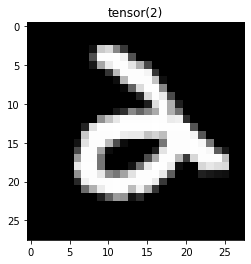

In [3]:
train_loader, test_loader = get_teacher_data(teacher_data, indices, 0)
import matplotlib.pyplot as plt
%matplotlib inline
images, labels = next(iter(train_loader))
plt.figure(figsize = (5, 4))
images = images.numpy()
i = np.random.randint(1, 64)
img = np.squeeze(images[i])
plt.imshow(img, cmap = 'gray')
plt.title(labels[i])

Checking for GPU (cuda)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Defining teacher model and initializing the models

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
teachers = [Teacher() for i in range(num_teachers)]
print(teachers[0])

Teacher(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Defining train function for teacher models

In [6]:
def train(model, train_loader, test_loader, epochs = 30, lr = 0.002, print_every = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    model.to(device)
    for e in range(1, epochs+1):
        train_loss = 0.0
        for images, labels in train_loader:
            #optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.size(0)
        train_loss /= len(train_loader.sampler)
        if e%print_every == 0:
            test_loss = 0.0
            accuracy = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                test_loss += loss.item()*images.size(0)
                _, idx = logits.topk(1, dim = 1)
                equals = idx == labels.view(*idx.shape)
                accuracy += torch.sum(equals.type(torch.FloatTensor)).item()
            accuracy /= len(test_loader.sampler)
            test_loss /= len(test_loader.sampler)
            print(f"Epoch {e}/{epochs}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Test loss: {test_loss:.3f}.. "
                  f"Test accuracy: {accuracy:.3f}")
            
    return model

Defining hyperparameters and training the 100 teacher models 

In [7]:
epochs = 30
lr = 0.002
print_every = 10

In [8]:
for i in range(num_teachers):
    train_loader, test_loader = get_teacher_data(teacher_data, indices, i)
    print("Training teacher", i+1)
    teachers[i] = train(teachers[i], train_loader, test_loader, epochs = epochs, lr = lr, print_every = print_every)
    

Training teacher 1
Epoch 10/30.. Train loss: 2.220.. Test loss: 2.221.. Test accuracy: 0.410
Epoch 20/30.. Train loss: 1.635.. Test loss: 1.627.. Test accuracy: 0.555
Epoch 30/30.. Train loss: 0.513.. Test loss: 0.799.. Test accuracy: 0.745
Training teacher 2
Epoch 10/30.. Train loss: 2.187.. Test loss: 2.198.. Test accuracy: 0.360
Epoch 20/30.. Train loss: 1.441.. Test loss: 1.471.. Test accuracy: 0.620
Epoch 30/30.. Train loss: 0.430.. Test loss: 0.853.. Test accuracy: 0.710
Training teacher 3
Epoch 10/30.. Train loss: 2.183.. Test loss: 2.201.. Test accuracy: 0.400
Epoch 20/30.. Train loss: 1.344.. Test loss: 1.427.. Test accuracy: 0.595
Epoch 30/30.. Train loss: 0.398.. Test loss: 0.834.. Test accuracy: 0.735
Training teacher 4
Epoch 10/30.. Train loss: 2.156.. Test loss: 2.174.. Test accuracy: 0.100
Epoch 20/30.. Train loss: 1.300.. Test loss: 1.308.. Test accuracy: 0.580
Epoch 30/30.. Train loss: 0.470.. Test loss: 0.965.. Test accuracy: 0.770
Training teacher 5
Epoch 10/30.. Tra

Epoch 10/30.. Train loss: 2.164.. Test loss: 2.215.. Test accuracy: 0.295
Epoch 20/30.. Train loss: 1.433.. Test loss: 1.509.. Test accuracy: 0.515
Epoch 30/30.. Train loss: 0.542.. Test loss: 0.795.. Test accuracy: 0.770
Training teacher 36
Epoch 10/30.. Train loss: 2.177.. Test loss: 2.231.. Test accuracy: 0.335
Epoch 20/30.. Train loss: 1.444.. Test loss: 1.645.. Test accuracy: 0.570
Epoch 30/30.. Train loss: 0.506.. Test loss: 1.004.. Test accuracy: 0.705
Training teacher 37
Epoch 10/30.. Train loss: 2.187.. Test loss: 2.207.. Test accuracy: 0.150
Epoch 20/30.. Train loss: 1.555.. Test loss: 1.556.. Test accuracy: 0.585
Epoch 30/30.. Train loss: 0.526.. Test loss: 0.659.. Test accuracy: 0.790
Training teacher 38
Epoch 10/30.. Train loss: 2.181.. Test loss: 2.196.. Test accuracy: 0.305
Epoch 20/30.. Train loss: 1.347.. Test loss: 1.391.. Test accuracy: 0.605
Epoch 30/30.. Train loss: 0.432.. Test loss: 0.948.. Test accuracy: 0.725
Training teacher 39
Epoch 10/30.. Train loss: 2.213.

Epoch 10/30.. Train loss: 2.202.. Test loss: 2.212.. Test accuracy: 0.345
Epoch 20/30.. Train loss: 1.500.. Test loss: 1.540.. Test accuracy: 0.550
Epoch 30/30.. Train loss: 0.505.. Test loss: 0.724.. Test accuracy: 0.810
Training teacher 70
Epoch 10/30.. Train loss: 2.192.. Test loss: 2.195.. Test accuracy: 0.470
Epoch 20/30.. Train loss: 1.426.. Test loss: 1.469.. Test accuracy: 0.625
Epoch 30/30.. Train loss: 0.399.. Test loss: 0.779.. Test accuracy: 0.745
Training teacher 71
Epoch 10/30.. Train loss: 2.204.. Test loss: 2.214.. Test accuracy: 0.315
Epoch 20/30.. Train loss: 1.561.. Test loss: 1.557.. Test accuracy: 0.500
Epoch 30/30.. Train loss: 0.595.. Test loss: 0.728.. Test accuracy: 0.750
Training teacher 72
Epoch 10/30.. Train loss: 2.199.. Test loss: 2.210.. Test accuracy: 0.435
Epoch 20/30.. Train loss: 1.472.. Test loss: 1.491.. Test accuracy: 0.705
Epoch 30/30.. Train loss: 0.508.. Test loss: 0.741.. Test accuracy: 0.780
Training teacher 73
Epoch 10/30.. Train loss: 2.173.

Epoch 10/30.. Train loss: 2.212.. Test loss: 2.233.. Test accuracy: 0.115
Epoch 20/30.. Train loss: 1.611.. Test loss: 1.660.. Test accuracy: 0.540
Epoch 30/30.. Train loss: 0.610.. Test loss: 0.866.. Test accuracy: 0.730
Training teacher 104
Epoch 10/30.. Train loss: 2.202.. Test loss: 2.217.. Test accuracy: 0.460
Epoch 20/30.. Train loss: 1.529.. Test loss: 1.586.. Test accuracy: 0.515
Epoch 30/30.. Train loss: 0.541.. Test loss: 0.764.. Test accuracy: 0.760
Training teacher 105
Epoch 10/30.. Train loss: 2.184.. Test loss: 2.215.. Test accuracy: 0.190
Epoch 20/30.. Train loss: 1.540.. Test loss: 1.604.. Test accuracy: 0.470
Epoch 30/30.. Train loss: 0.567.. Test loss: 0.729.. Test accuracy: 0.780
Training teacher 106
Epoch 10/30.. Train loss: 2.203.. Test loss: 2.217.. Test accuracy: 0.320
Epoch 20/30.. Train loss: 1.499.. Test loss: 1.555.. Test accuracy: 0.570
Epoch 30/30.. Train loss: 0.444.. Test loss: 0.778.. Test accuracy: 0.735
Training teacher 107
Epoch 10/30.. Train loss: 2.

Epoch 10/30.. Train loss: 2.187.. Test loss: 2.197.. Test accuracy: 0.115
Epoch 20/30.. Train loss: 1.488.. Test loss: 1.505.. Test accuracy: 0.635
Epoch 30/30.. Train loss: 0.448.. Test loss: 0.819.. Test accuracy: 0.765
Training teacher 138
Epoch 10/30.. Train loss: 2.193.. Test loss: 2.249.. Test accuracy: 0.100
Epoch 20/30.. Train loss: 1.598.. Test loss: 1.712.. Test accuracy: 0.520
Epoch 30/30.. Train loss: 0.455.. Test loss: 0.812.. Test accuracy: 0.720
Training teacher 139
Epoch 10/30.. Train loss: 2.199.. Test loss: 2.226.. Test accuracy: 0.120
Epoch 20/30.. Train loss: 1.584.. Test loss: 1.629.. Test accuracy: 0.455
Epoch 30/30.. Train loss: 0.395.. Test loss: 0.760.. Test accuracy: 0.770
Training teacher 140
Epoch 10/30.. Train loss: 2.178.. Test loss: 2.191.. Test accuracy: 0.255
Epoch 20/30.. Train loss: 1.433.. Test loss: 1.455.. Test accuracy: 0.635
Epoch 30/30.. Train loss: 0.439.. Test loss: 0.813.. Test accuracy: 0.745
Training teacher 141
Epoch 10/30.. Train loss: 2.

Epoch 10/30.. Train loss: 2.180.. Test loss: 2.193.. Test accuracy: 0.415
Epoch 20/30.. Train loss: 1.429.. Test loss: 1.451.. Test accuracy: 0.650
Epoch 30/30.. Train loss: 0.438.. Test loss: 0.822.. Test accuracy: 0.700
Training teacher 172
Epoch 10/30.. Train loss: 2.192.. Test loss: 2.199.. Test accuracy: 0.455
Epoch 20/30.. Train loss: 1.390.. Test loss: 1.432.. Test accuracy: 0.675
Epoch 30/30.. Train loss: 0.300.. Test loss: 0.794.. Test accuracy: 0.795
Training teacher 173
Epoch 10/30.. Train loss: 2.153.. Test loss: 2.207.. Test accuracy: 0.120
Epoch 20/30.. Train loss: 1.419.. Test loss: 1.558.. Test accuracy: 0.530
Epoch 30/30.. Train loss: 0.452.. Test loss: 0.925.. Test accuracy: 0.685
Training teacher 174
Epoch 10/30.. Train loss: 2.186.. Test loss: 2.216.. Test accuracy: 0.195
Epoch 20/30.. Train loss: 1.557.. Test loss: 1.661.. Test accuracy: 0.510
Epoch 30/30.. Train loss: 0.558.. Test loss: 0.784.. Test accuracy: 0.725
Training teacher 175
Epoch 10/30.. Train loss: 2.

Loading the Student Data

In [9]:
num_student_train = int(0.8*len(student_data))
indices = list(range(len(student_data)))
np.random.shuffle(indices)
train_idx, test_idx = indices[:num_student_train], indices[num_student_train:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

student_train_loader = torch.utils.data.DataLoader(student_data, batch_size=batch_size, shuffle = False, num_workers=0, sampler = train_sampler)
student_test_loader = torch.utils.data.DataLoader(student_data, batch_size=batch_size, shuffle = False, num_workers=0, sampler = test_sampler)
    

Taking teacher predictions on student training data 

In [10]:
teacher_preds = np.zeros((num_teachers, num_student_train)).astype(int)
true_labels = np.zeros((num_student_train)).astype(int)

In [11]:
torch.manual_seed(1)
preds = 0
for images, labels in student_train_loader:
    for i in range(num_teachers):
        model = teachers[i]
        model.to(device)
        
    
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        _, top_class = logits.topk(1, dim = 1)
        teacher_preds[i,preds:(preds+batch_size)] = top_class.cpu().numpy().squeeze(1).astype(int)
        true_labels[preds:(preds+batch_size)] = labels.cpu().numpy()
        
    preds += batch_size
np.transpose(teacher_preds)
print(teacher_preds.shape)

(200, 8000)


Adding noise with the Laplacian Mechanism

In [12]:
new_labels = list()
epsilon = 0.1

beta = 1 / epsilon
counts = np.zeros((10,8000)).astype(int)
for i in range(8000):
    label_counts = np.bincount(teacher_preds[:, i], minlength = 10)
    counts[:, i] = label_counts 
    for j in range(10):
        label_counts[j] += np.random.laplace(1, beta, 1)
        new = np.argmax(label_counts)
    new_labels.append(new)
new_labels = np.array(new_labels)
print(new_labels.shape)

(8000,)


Performing the PATE Analysis

In [13]:
from syft.frameworks.torch.dp import pate

data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=teacher_preds, indices=new_labels, noise_eps=epsilon, delta=1e-5)


print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

assert data_dep_eps < data_ind_eps


Data Independent Epsilon: 331.5129254649703
Data Dependent Epsilon: 50.103791277682106


Creating a new train loader for the student training data with new labels predicted by the teachers

In [14]:
def student_loader(student_train_loader, new_labels):
    torch.manual_seed(1)
    for i, (data, labels) in enumerate(iter(student_train_loader)):
        yield data, torch.from_numpy(new_labels[i*len(data):(i+1)*len(data)])

Defining and initializing student model

In [15]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
student = Student()
student

Student(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Setting hyperparameters and training the model 

In [16]:
epochs = 50
lr = 0.1
print_every = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student.parameters(), lr = lr)
    

In [17]:

student.to(device)
for e in range(1, epochs+1):
    train_loss = 0.0

    new_train_loader = student_loader(student_train_loader, new_labels)

    for images, labels in new_train_loader:
       
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        logits = student(images)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss /= 8000
    if e % print_every == 0:
        test_loss = 0.0
        accuracy = 0
        for images, labels in student_test_loader:
            
            images, labels = images.to(device), labels.to(device)
            logits = student(images)
            loss = criterion(logits, labels)
            test_loss += loss.item()*images.size(0)
            _, idx = logits.topk(1, dim = 1)
            equals = idx == labels.view(*idx.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).item()
        accuracy /= len(student_test_loader.sampler)
        test_loss /= len(student_test_loader.sampler)
        print(f"Epoch {e}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Test loss: {test_loss:.3f}.. "
              f"Test accuracy: {accuracy:.3f}")

Epoch 5/50.. Train loss: 0.131.. Test loss: 0.826.. Test accuracy: 0.824
Epoch 10/50.. Train loss: 0.072.. Test loss: 1.095.. Test accuracy: 0.826
Epoch 15/50.. Train loss: 0.044.. Test loss: 1.336.. Test accuracy: 0.829
Epoch 20/50.. Train loss: 0.027.. Test loss: 1.540.. Test accuracy: 0.831
Epoch 25/50.. Train loss: 0.018.. Test loss: 1.734.. Test accuracy: 0.833
Epoch 30/50.. Train loss: 0.013.. Test loss: 1.895.. Test accuracy: 0.831
Epoch 35/50.. Train loss: 0.009.. Test loss: 2.048.. Test accuracy: 0.830
Epoch 40/50.. Train loss: 0.006.. Test loss: 2.140.. Test accuracy: 0.832
Epoch 45/50.. Train loss: 0.005.. Test loss: 2.229.. Test accuracy: 0.832
Epoch 50/50.. Train loss: 0.004.. Test loss: 2.309.. Test accuracy: 0.832
